In [109]:
import warnings
warnings.filterwarnings('ignore')

import time
import pandas as pd
import numpy as np
from scipy import stats
import scipy.stats as st
from matplotlib import style
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LinearRegression

%matplotlib inline

style.use("fivethirtyeight")
pd.set_option("display.max_columns", None)

## Joblib: parallelization

__Joblib__: provides a simple helper class to write parallel for loops using multiprocessing. The core idea is to write the code to be executed as a generator expression, and convert it to parallel computing.
- n_jobs=-1 is a common usage pattern that instructs Parallel to use all available CPU cores on the system.

In [2]:
from math import sqrt
[sqrt(i ** 2) for i in range(10)]

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]

In [3]:
from joblib import Parallel, delayed
Parallel(n_jobs=2)(delayed(sqrt)(i ** 2) for i in range(10))

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]

In [6]:
def square(x):
    time.sleep(1)  # Simulating a time-consuming task
    return x ** 2
 
# List of numbers
numbers = [1, 2, 3, 4, 5]
 
# Without using delayed
start = time.time()
results_no_delayed =[square(number) for number in numbers]
end = time.time()
time_no_delayed = end - start
 
# Using delayed
start = time.time()
delayed_calls = [delayed(square)(number) for number in numbers]
results_delayed = Parallel(n_jobs=-1)(delayed_calls)
end = time.time()
time_delayed = end - start
 
print("Results without delayed:", results_no_delayed)
print("Results with delayed:   ", results_delayed)
print("Time without delayed:   ", time_no_delayed)
print("Time with delayed:      ", time_delayed)

Results without delayed: [1, 4, 9, 16, 25]
Results with delayed:    [1, 4, 9, 16, 25]
Time without delayed:    5.029967308044434
Time with delayed:       1.0595107078552246


---

## Propensity Score Process

In [11]:
data = pd.read_csv("./data/learning_mindset.csv")
data.sample(5, random_state = 5) ## show 5 randm samples

,schoolid,intervention,achievement_score,...,school_ethnic_minority,school_poverty,school_size
259,73,1,1.480828,...,-0.515202,-0.169849,0.173954
3435,76,0,-0.987277,...,-1.310927,0.224077,-0.426757
9963,4,0,-0.152340,...,0.875012,-0.724801,0.761781
4488,67,0,0.358336,...,0.315755,0.054586,1.862187
2637,16,1,1.360920,...,-0.033161,-0.982274,1.591641


Check randomization and confounding. 
- One possible reason for this is that the treatment variable is measured by the __student's receipt of the seminar__. So, although the opportunity to participate was random, __participation itself is not__.
- One evidence of this is how the student's __success expectation__ is correlated with the participation in the seminar. Students with higher self-reported success expectation are more likely to have joined the growth mindset seminar.

In [12]:
data.groupby("success_expect")["intervention"].mean()

success_expect
1    0.271739
2    0.265957
3    0.294118
4    0.271617
5    0.311070
6    0.354287
7    0.362319
Name: intervention, dtype: float64

Run regression model directly to check ATE $E[Y|T=1] - E[Y|T=0]$

In [15]:
smf.ols("achievement_score ~ intervention", data=data).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.1538,0.012,-13.201,0.000,-0.177,-0.131
intervention,0.4723,0.020,23.133,0.000,0.432,0.512


If it's biased, the difference between treated and untreated is probably smaller than this (bias is positive). What can we do?
- Linear Regression by adding confounders
- Matching
- __Propensity Score (focus here)__
- Doubly Robust Estimation

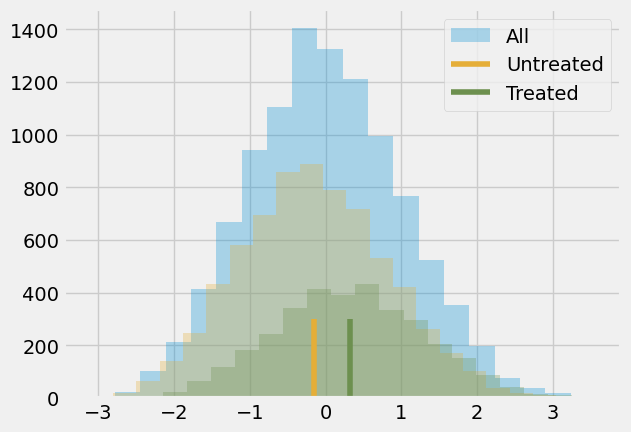

In [20]:
plt.hist(data["achievement_score"], bins=20, alpha=0.3, label="All")
plt.hist(data.query("intervention==0")["achievement_score"], bins=20, alpha=0.3, color="C2")
plt.hist(data.query("intervention==1")["achievement_score"], bins=20, alpha=0.3, color="C3")
plt.vlines(-0.1538, 0, 300, label="Untreated", color="C2")
plt.vlines(-0.1538+0.4723, 0, 300, label="Treated", color="C3")
plt.legend();

In [21]:
## convert the categorical features in the dataset to dummies
categ = ["ethnicity", "gender", "school_urbanicity"]
cont = ["school_mindset", "school_achievement", "school_ethnic_minority", "school_poverty", "school_size"]

data_with_categ = pd.concat([
    data.drop(columns=categ), # dataset without the categorical features
    pd.get_dummies(data[categ], columns=categ, drop_first=False)# categorical features converted to dummies
], axis=1)

print(data_with_categ.shape)

(10391, 32)


In [27]:
## Estimate the propensity score using Logistic Regression.
T = 'intervention'
Y = 'achievement_score'
X = data_with_categ.columns.drop(['schoolid', T, Y])

ps_model = LogisticRegression(C=1e6).fit(data_with_categ[X], data_with_categ[T])

data_ps = data.assign(propensity_score = ps_model.predict_proba(data_with_categ[X])[:, 1])

data_ps[["intervention", "achievement_score", "propensity_score"]].head(10)

,intervention,achievement_score,propensity_score
0,1,0.277359,0.315489
1,1,-0.449646,0.263798
2,1,0.769703,0.344024
3,1,-0.121763,0.344024
4,1,1.526147,0.367789
5,1,0.009607,0.344024
6,1,1.743033,0.367789
7,1,0.953294,0.367789
8,1,2.367780,0.338334
9,1,1.264409,0.338300


__Step 1: Use propensity score to make sure that the propensity score weight indeed reconstructs a population where everyone is treated__.  
- By producing weights $1/e(x)$, it creates the population where everyone is treated
- By providing the weights $1/(1-e(x))$ it creates the population where everyone is untreated.

In [33]:
weight_t = 1/data_ps.query("intervention==1")["propensity_score"]
weight_nt = 1/(1-data_ps.query("intervention==0")["propensity_score"])
print("Original Sample Size", data.shape[0])
print("Treated Population Sample Size", sum(weight_t))
print("Untreated Population Sample Size", sum(weight_nt))

Original Sample Size 10391
Treated Population Sample Size 10388.575092093015
Untreated Population Sample Size 10391.438139669131


__Step 2: Use propensity score to find evidence of confounding__. 
- If a segmentation of the population has a higher propensity score than another, it means that __something which is not random is causing the treatment__. 
- If that same thing is also causing the outcome, we have confounding. 
- In our case, we can see that students that reported to be more ambitious also have a higher probability of attending the growth mindset seminar.

Text(0.5, 1.0, 'Confounding Evidence')

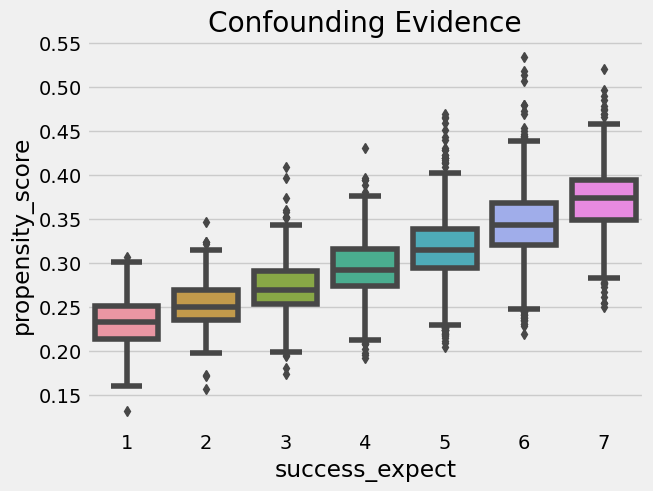

In [31]:
sns.boxplot(x="success_expect", y="propensity_score", data=data_ps)
plt.title("Confounding Evidence")

__Step 3: Use propensity score to check there is overlap between the treated and untreated population.__
- To do so, we can see the empirical distribution of the propensity score on the untreated and on the treated. 
- Looking at the image below, we can see that no one has a propensity score of zero and that even in lower regions of the propensity score we can find both treated and untreated individuals. 
- This is what we call a nicely __balanced__ treated and untreated population. 

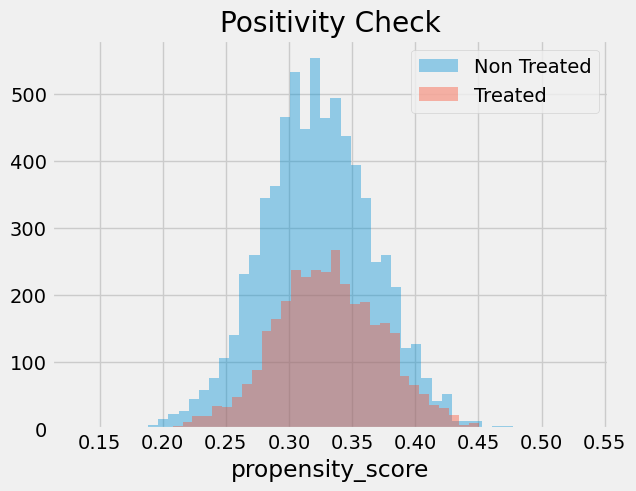

In [32]:
sns.distplot(data_ps.query("intervention==0")["propensity_score"], kde=False, label="Non Treated")
sns.distplot(data_ps.query("intervention==1")["propensity_score"], kde=False, label="Treated")
plt.title("Positivity Check")
plt.legend();

__Step 4: Finally, we can use our propensity score weighting estimator to estimate the ATE average treatment effect.__
- propensity score weighting estimator:

$
E\bigg[Y \dfrac{T-e(x)}{e(x)(1-e(x))}\bigg]
$


In [34]:
weight = ((data_ps["intervention"]-data_ps["propensity_score"]) /
          (data_ps["propensity_score"]*(1-data_ps["propensity_score"])))

y1 = sum(data_ps.query("intervention==1")["achievement_score"]*weight_t) / len(data)
y0 = sum(data_ps.query("intervention==0")["achievement_score"]*weight_nt) / len(data)

ate = np.mean(weight * data_ps["achievement_score"])

print("Y1:", y1)
print("Y0:", y0)
print("ATE", ate)

Y1: 0.25958063246387597
Y0: -0.1289225549136946
ATE 0.3885031873775723


__Step 5: Account for Errors in the Estimation process__
- Since we estimate $P(x)$ with $\hat{P}(x)$, we need to account for the __errors__ in this estimation process.
- This can be done by __bootstrapping__ the whole procedure, i.e. __sampling with replacement__ from the original data and computing the ATE. Then repeat this many times to get the __distribution of the ATE estimate__.

In [40]:
print(data_with_categ.shape)
data_sample = data_with_categ.sample(frac = 1, replace = True) # a random 100% sample is drawn
print(data_sample.shape)
print(data_sample.head())

(10391, 32)
(10391, 32)
      schoolid  intervention  achievement_score  ...  school_urbanicity_2  \
1755        39             1           1.660001  ...                    1   
1177        58             1           0.542002  ...                    0   
921         62             1           0.492635  ...                    0   
5943        57             0          -0.253094  ...                    1   
4465        67             0          -0.318222  ...                    0   

      school_urbanicity_3  school_urbanicity_4  
1755                    0                    0  
1177                    0                    0  
921                     0                    1  
5943                    0                    0  
4465                    0                    1  

[5 rows x 32 columns]


In [56]:
# define function that computes the IPTW estimator
def run_ps(df, X, T, y):
    # estimate the propensity score
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    
    weight = (df[T]-ps) / (ps*(1-ps)) # define the weights
    return np.mean(weight * df[y]) # compute the ATE

np.random.seed(88)
# run 5000 bootstrap samples
bootstrap_sample = 5000

ates = Parallel(n_jobs=4)(delayed(run_ps)(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                          for _ in range(bootstrap_sample))
ates = np.array(ates)

In [57]:
ates.shape

(5000,)

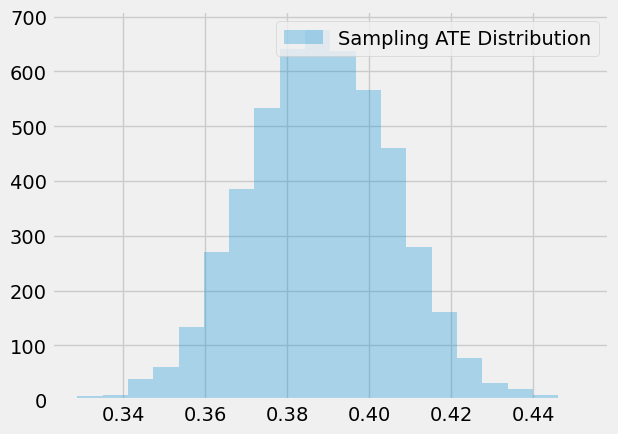

In [58]:
plt.hist(ates, bins=20, alpha=0.3, label='Sampling ATE Distribution')
plt.legend()

The ATE is then the mean of the bootstrap samples. 

__Percentile Method for Constructing Confidence Intervals (Non-parametric)__
- Inspect the quantiles of the bootstrap distribution. For the 95% C.I., we use the 2.5 and 97.5 percentiles.
- This works regardless of the shape of the sampling distribution.

In [59]:
print(f"ATE: {ates.mean()}")
print(f"95% C.I.: {(np.percentile(ates, 2.5), np.percentile(ates, 97.5))}")

ATE: 0.3881907897019689
95% C.I.: (0.3542489247760043, 0.4221207638102843)


__Standard Deviation Method for Constructing Confidence Intervals (Parametric)__:
- Can be used when the bootstrap distribution is approximately normal.

In [69]:
# can't use st.sem(ates) as it's for computing standard error of the mean. Here we already have the bootstrap distribution.
st.t.interval(alpha = 0.95, df = len(ates)-1, loc = np.mean(ates), scale = np.std(ates)) 


(0.35364665394986955, 0.42273492545406827)

## Query, Assign, Pivot

### Query
- Query the rows based on the expression (single or multiple column conditions).
- This is to replace boolean indexing and positional indexing
    - boolean indexing: df[ (df['smoker']=='No') & (df['sex'] =='Female') ]
    - positional indexing using .loc[] and .iloc[]: df.loc[(df['smoker'] == 'No') & (df['sex'] == 'Female')]

In [70]:
cigar = (pd.read_csv("data/smoking.csv")
         .drop(columns=["lnincome","beer", "age15to24"]))

cigar.head()

,state,year,cigsale,retprice,california,after_treatment
0,1,1970,89.800003,39.599998,False,False
1,1,1971,95.400002,42.700001,False,False
2,1,1972,101.099998,42.299999,False,False
3,1,1973,102.900002,42.099998,False,False
4,1,1974,108.199997,43.099998,False,False


In [75]:
cigar.query('year == 1970').head()

,state,year,cigsale,retprice,california,after_treatment
0,1,1970,89.800003,39.599998,False,False
31,2,1970,100.300003,36.700001,False,False
62,3,1970,123.000000,38.799999,True,False
93,4,1970,124.800003,29.400000,False,False
124,5,1970,120.000000,42.200001,False,False


In [77]:
cigar.query('california').head()

,state,year,cigsale,retprice,california,after_treatment
62,3,1970,123.000000,38.799999,True,False
63,3,1971,121.000000,39.700001,True,False
64,3,1972,123.500000,39.900002,True,False
65,3,1973,124.400002,39.900002,True,False
66,3,1974,126.699997,41.900002,True,False


In [78]:
cigar.query('~california').head()

,state,year,cigsale,retprice,california,after_treatment
0,1,1970,89.800003,39.599998,False,False
1,1,1971,95.400002,42.700001,False,False
2,1,1972,101.099998,42.299999,False,False
3,1,1973,102.900002,42.099998,False,False
4,1,1974,108.199997,43.099998,False,False


In [79]:
cigar.query('~california & after_treatment').head()

,state,year,cigsale,retprice,california,after_treatment
19,1,1989,105.599998,122.300003,False,True
20,1,1990,108.599998,139.100006,False,True
21,1,1991,107.900002,144.399994,False,True
22,1,1992,109.099998,172.199997,False,True
23,1,1993,108.500000,176.199997,False,True


---

### Assign
- Assign new columns to a DataFrame.
- Returns a new object with all original columns in addition to new ones. 
- Existing columns that are re-assigned will be overwritten.

In [85]:
cigar.assign(temp = 2).head()

,state,year,cigsale,...,california,after_treatment,temp
0,1,1970,89.800003,...,False,False,2
1,1,1971,95.400002,...,False,False,2
2,1,1972,101.099998,...,False,False,2
3,1,1973,102.900002,...,False,False,2
4,1,1974,108.199997,...,False,False,2


In [88]:
# method 1
cigar.assign(cigsale_new = cigar['cigsale'] * 2).head()

,state,year,cigsale,...,california,after_treatment,cigsale_new
0,1,1970,89.800003,...,False,False,179.600006
1,1,1971,95.400002,...,False,False,190.800003
2,1,1972,101.099998,...,False,False,202.199997
3,1,1973,102.900002,...,False,False,205.800003
4,1,1974,108.199997,...,False,False,216.399994


In [89]:
# method 2
cigar.assign(cigsale_new = lambda x: x.cigsale * 2).head()

,state,year,cigsale,...,california,after_treatment,cigsale_new
0,1,1970,89.800003,...,False,False,179.600006
1,1,1971,95.400002,...,False,False,190.800003
2,1,1972,101.099998,...,False,False,202.199997
3,1,1973,102.900002,...,False,False,205.800003
4,1,1974,108.199997,...,False,False,216.399994


In [90]:
cigar.assign(cigsale_new = lambda x: x.cigsale * 2, cigsale_old = lambda x: x.cigsale / 2).head()

,state,year,cigsale,...,after_treatment,cigsale_new,cigsale_old
0,1,1970,89.800003,...,False,179.600006,44.900002
1,1,1971,95.400002,...,False,190.800003,47.700001
2,1,1972,101.099998,...,False,202.199997,50.549999
3,1,1973,102.900002,...,False,205.800003,51.450001
4,1,1974,108.199997,...,False,216.399994,54.099998


### Pivot
- index: Column to use to make new frame’s index. If not given, uses existing index.
- columns: Column to use to make new frame’s columns.
- values: Column(s) to use for populating new frame’s values. If not specified, all remaining columns will be used and the result will have hierarchically indexed columns.

In [104]:
cigar.assign(california = np.where(cigar["california"], "California", "Other States")) \
.groupby(["year", "california"])["cigsale"] \
.mean() \
.reset_index()

,year,california,cigsale
0,1970,California,123.000000
1,1970,Other States,120.084212
2,1971,California,121.000000
3,1971,Other States,123.863158
4,1972,California,123.500000
...,...,...,...
57,1998,Other States,100.957894
58,1999,California,47.200001
59,1999,Other States,97.594737
60,2000,California,41.599998


In [103]:
cigar.assign(california = np.where(cigar["california"], "California", "Other States")) \
.groupby(["year", "california"])["cigsale"] \
.mean() \
.reset_index() \
.pivot(index = "year", columns = "california", values = "cigsale")

california,California,Other States
year,,
1970,123.000000,120.084212
1971,121.000000,123.863158
1972,123.500000,129.178948
1973,124.400002,131.539473
1974,126.699997,134.668421
1975,127.099998,136.931579
1976,128.000000,141.260526
1977,126.400002,141.089473
1978,126.099998,140.473684


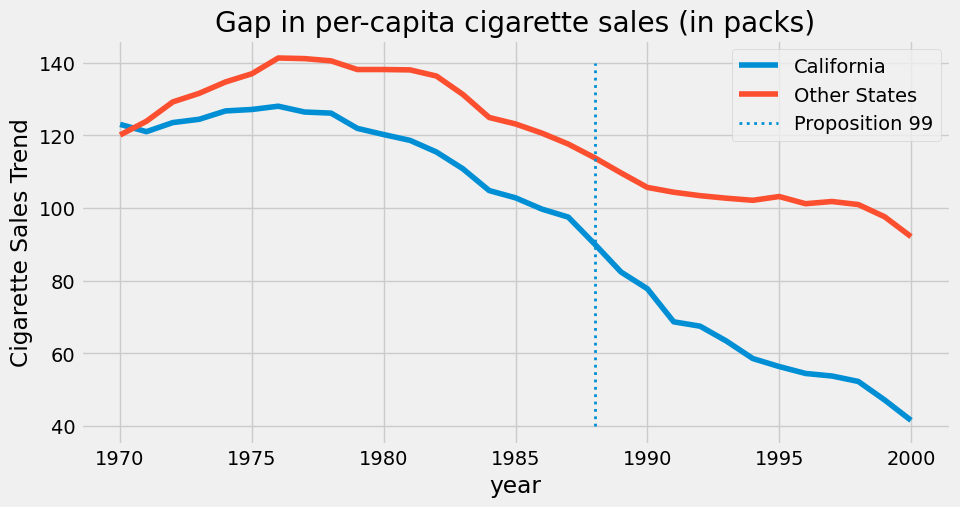

In [106]:
ax = plt.subplot(1, 1, 1)

(cigar
 .assign(california = np.where(cigar["california"], "California", "Other States"))
 .groupby(["year", "california"])
 ["cigsale"]
 .mean()
 .reset_index()
 .pivot("year", "california", "cigsale")
 .plot(ax=ax, figsize=(10,5)))

plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Cigarette Sales Trend")
plt.title("Gap in per-capita cigarette sales (in packs)")
plt.legend();  

In [107]:
cigar.head()

,state,year,cigsale,retprice,california,after_treatment
0,1,1970,89.800003,39.599998,False,False
1,1,1971,95.400002,42.700001,False,False
2,1,1972,101.099998,42.299999,False,False
3,1,1973,102.900002,42.099998,False,False
4,1,1974,108.199997,43.099998,False,False


In [118]:
features = ["cigsale", "retprice"]

inverted = (cigar.query("~after_treatment") # filter pre-intervention period
            .pivot(index='state', columns="year", values = features) # make one column per year and one row per state
            .T) # flip the table to have one column per state

inverted

state                  1           2           3           4           5   \
         year                                                               
cigsale  1970   89.800003  100.300003  123.000000  124.800003  120.000000   
         1971   95.400002  104.099998  121.000000  125.500000  117.599998   
         1972  101.099998  103.900002  123.500000  134.300003  110.800003   
         1973  102.900002  108.000000  124.400002  137.899994  109.300003   
         1974  108.199997  109.699997  126.699997  132.800003  112.400002   
         1975  111.699997  114.800003  127.099998  131.000000  110.199997   
         1976  116.199997  119.099998  128.000000  134.199997  113.400002   
         1977  117.099998  122.599998  126.400002  132.000000  117.300003   
         1978  123.000000  127.300003  126.099998  129.199997  117.500000   
         1979  121.400002  126.500000  121.900002  131.500000  117.400002   
         1980  123.199997  131.800003  120.199997  131.000000  118.000000   
         1981  119.599998  128.699997  118.599998  133.800003  116.400002   
         1982  119.099998  127.400002  115.400002  130.500000  114.699997   
         1983  116.300003  128.000000  110.800003  125.300003  114.099998   
         1984  113.000000  123.099998  104.800003  119.699997  112.500000   
         1985  114.500000  125.800003  102.800003  112.400002  111.000000   
         1986  116.300003  126.000000   99.699997  109.900002  108.500000   
         1987  114.000000  122.300003   97.500000  102.400002  109.000000   
         1988  112.099998  121.500000   90.099998   94.599998  104.800003   
retprice 1970   39.599998   36.700001   38.799999   29.400000   42.200001   
         1971   42.700001   38.799999   39.700001   31.100000   45.500000   
         1972   42.299999   44.099998   39.900002   31.200001   51.299999   
         1973   42.099998   45.099998   39.900002   32.700001   50.599998   
         1974   43.099998   45.500000   41.900002   38.099998   52.500000   
         1975   46.599998   48.599998   45.000000   41.700001   54.500000   
         1976   50.400002   50.900002   48.299999   44.799999   57.599998   
         1977   50.099998   52.599998   49.000000   44.700001   58.400002   
         1978   55.099998   56.500000   58.700001   57.400002   61.700001   
         1979   56.799999   58.400002   60.099998   52.799999   64.400002   
         1980   60.599998   61.500000   62.099998   54.599998   67.000000   
         1981   68.800003   64.699997   66.400002   58.099998   80.099998   
         1982   73.099998   72.099998   72.800003   61.400002   85.599998   
         1983   84.400002   82.000000   84.900002   73.300003   95.599998   
         1984   90.800003   93.599998   94.900002   83.400002  113.500000   
         1985   99.000000   98.500000   98.000000   93.099998  118.599998   
         1986  103.000000  103.599998  104.400002   95.099998  118.500000   
         1987  110.000000  113.000000  103.900002  108.599998  122.699997   
         1988  114.400002  119.900002  117.400002  116.000000  129.699997   

state                  6           7           8           9           10  \
         year                                                               
cigsale  1970  155.000000  109.900002  102.400002  124.800003  134.600006   
         1971  161.100006  115.699997  108.500000  125.599998  139.300003   
         1972  156.300003  117.000000  126.099998  126.599998  149.199997   
         1973  154.699997  119.800003  121.800003  124.400002  156.000000   
         1974  151.300003  123.699997  125.599998  131.899994  159.600006   
         1975  147.600006  122.900002  123.300003  131.800003  162.399994   
         1976  153.000000  125.900002  125.099998  134.399994  166.600006   
         1977  153.300003  127.900002  125.000000  134.000000  173.000000   
         1978  155.500000  130.600006  122.800003  136.699997  150.899994   
         1979  150.199997  131.000000  117.500000  135.300003  148.89999